In [1]:
import pageviewapi.period
import json
from datetime import datetime
import pageviewapi
import urllib, urllib.request
import bs4
import re
import pandas as pd
import wikipedia
from flashtext import KeywordProcessor
from collections import Counter
from math import floor, log
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
def get_pageviews_unstandarized(term):
    correctedterm = wikipedia.search(term)[0]
    x = pageviewapi.per_article('en.wikipedia', correctedterm, 
                                '2015112400', 
                                '2018112400', 
                                access='all-access', 
                                agent='all-agents', 
                                granularity='daily')
    y = np.array([[datetime.strptime(dictio['timestamp'], '%Y%m%d00'), 
                   dictio['views']] for dictio in list(x.values())[0]])

    df = pd.DataFrame(y[:,1], index = y[:,0], columns = [term])
    return df

In [3]:
def get_pageviews(term):
    correctedterm = wikipedia.search(term)[0]
    x = pageviewapi.per_article('en.wikipedia', correctedterm, 
                                '2015112400', 
                                '2018112400', 
                                access='all-access', 
                                agent='all-agents', 
                                granularity='daily')
    y = np.array([[datetime.strptime(dictio['timestamp'], '%Y%m%d00'), 
                   dictio['views']] for dictio in list(x.values())[0]])

    mean = y[:,1].mean()
    sd = y[:,1].std()
    y[:,1] = (y[:,1]-mean)/sd

    df = pd.DataFrame(y[:,1], index = y[:,0], columns = [term])
    return df

In [5]:
# getWikiPage is a function that was used in class.
def getWikiPage(page, ignore = None):
    URL = "http://en.wikipedia.org/wiki/Special:Export/%s" % urllib.parse.quote(page)
    if ignore == None or URL not in ignore:
        req = urllib.request.Request(URL, 
                                     headers={'User-Agent': 'OII SDS class 2018.1/Hogan'})
        infile = urllib.request.urlopen(req)
        return infile.read(), URL
    else:
        pass

def get_wikipedia_links(x, pages_of_interest=None, ignore = None):
    x = wikipedia.search(x)[0]
    data, URL = getWikiPage(x, ignore = ignore)
    soup = bs4.BeautifulSoup(data.decode('utf8'), "lxml")
    text_to_parse = soup.mediawiki.page.text
    text_to_parse = text_to_parse.lower()

    re_inner_links = re.compile(r'\[\[.*?\]\]')
    inner_links = re_inner_links.findall(text_to_parse)


    d = dict()
    d1 = dict()
    for link in inner_links:
        link = re.sub(r'\[|\]','',link)
        if ":" in link:
            pass
        elif "#" in link:
            pass
        elif "|" in link:
            pass
        else:
            d[link] = [link]
            try:
                d1[link] += 1
                pass
            except:
                d1[link] = 1
                pass

    for link in inner_links:
        link = re.sub(r'\[|\]','',link)
        if ":" in link:
            pass
        elif "#" in link:
            pass
        elif "|" in link:
            link = link.split("|")
            if link[1] in d.keys():
                d1[link[1]] += 1
                pass
            else:
                d[link[0]] = [link[0], link[1]]
                try:
                    d1[link[0]] += 1
                    pass
                except:
                    d1[link[0]] = 1
                    pass
                
    d1 = {k:v for (k,v) in d1.items() }
    d = { k: d[k] for k in d1.keys() }       
    
    if pages_of_interest != None:
        d = {k: d[k] for k in pages_of_interest if k in d}
        d1 = {k: d1[k] for k in pages_of_interest if k in d1}
        
        d2 = dict()
        keyword_processor = KeywordProcessor()
        keyword_found = []
        keyword_processor.add_keywords_from_dict(d)
        keywords_found = keyword_processor.extract_keywords(text_to_parse, span_info=True)
        d2 = Counter([tupl[0] for tupl in keywords_found])
               
        d3 = {k: d1.get(k) + d2.get(k) - 1 for k in set(d1)}
        df = pd.DataFrame.from_dict(d3,orient='index', columns = [x])
        df = df.sort_values(by=[x], ascending=False)
        df.loc[x.lower(), x] = 0
    else:
        d2 = dict()
        keyword_processor = KeywordProcessor()
        keyword_found = []
        keyword_processor.add_keywords_from_dict(d)
        keywords_found = keyword_processor.extract_keywords(text_to_parse, span_info=True)
        d2 = Counter([tupl[0] for tupl in keywords_found])

        d3 = {k: d1.get(k) + d2.get(k) - 1 for k in set(d1)}
        df = pd.DataFrame.from_dict(d3,orient='index', columns = [x])
        c = floor(log(len(text_to_parse))*5)
        df = df.sort_values(by=x, ascending=False)
        df = df[0:c]
        df.loc[x.lower(), x] = 0
        
    dl = pd.DataFrame.from_dict({x:[len(text_to_parse)]}, 
                                orient='index', 
                                columns = ['Length'])
    
    return df, dl, URL, x

In [6]:
def wikicorrelation(originalterm):

    # Get the hyperlinks in the original article
    wiki_links = get_wikipedia_links(originalterm)[0]

    # Get the pageviews in the original article over time 
    original_views = get_pageviews(originalterm).iloc[:,0]
    
    # wiki_links_list is the linked articles (without including the original 
    # term, which does not link itself)
    wiki_links_list = set(wiki_links.index) - set([originalterm.lower()])

    df = pd.DataFrame()
    # Populate dataframe with the pageview of the linked articles
    for term in wiki_links_list:
        newdf = get_pageviews(term)
        df = pd.concat([df,newdf], axis = 1, sort=True)

    # Order index alphabetically    
    df = df.reindex(sorted(df.columns), axis=1)
    
    # Calculate the weighted average of pageviews from the linked articles
    weights = wiki_links[0:-1].sort_index().values
    weights = [item for sublist in weights for item in sublist]

    mean_views = df.multiply(weights, axis = 1).sum(axis=1)/sum(weights)
    
    return original_views, mean_views

In [17]:
hume_original_views, hume_mean_views = wikicorrelation("David Hume")
neymar_original_views, neymar_mean_views = wikicorrelation("Neymar")
ubuntu_original_views, ubuntu_mean_views = wikicorrelation("Ubuntu")
pink_original_views, pink_mean_views = wikicorrelation("Pink Floyd")
bitcoin_original_views, bitcoin_mean_views = wikicorrelation("Bitcoin")
cubism_original_views, cubism_mean_views = wikicorrelation("Cubism")

In [18]:
dfall = pd.DataFrame([hume_original_views, hume_mean_views, 
                      neymar_original_views, neymar_mean_views,
                     ubuntu_original_views, ubuntu_mean_views, 
                      pink_original_views, pink_mean_views,
                     bitcoin_original_views, bitcoin_mean_views, 
                      cubism_original_views, cubism_mean_views])
dfall = dfall.transpose()
dfall.columns = ['David Hume (actual)', 'David Hume (estimated)', 
                 'Neymar (actual)', 'Neymar (estimated)', 
                 'Ubuntu (actual)', 'Ubuntu (estimated)', 
                 'Pink Floyd (actual)', 'Pink Floyd (estimated)', 
                 'Bitcoin (actual)', 'Bitcoin (estimated)', 
                 "Cubism (actual)", "Cubism (estimated)"]

round(dfall.corr(),3)

,David Hume (actual),David Hume (estimated),Neymar (actual),Neymar (estimated),Ubuntu (actual),Ubuntu (estimated),Pink Floyd (actual),Pink Floyd (estimated),Bitcoin (actual),Bitcoin (estimated),Cubism (actual),Cubism (estimated)
David Hume (actual),1.000,0.739,-0.042,0.006,0.129,0.313,0.072,0.271,-0.039,0.342,0.635,0.634
David Hume (estimated),0.739,1.000,-0.117,-0.022,0.160,0.427,0.159,0.360,-0.004,0.464,0.733,0.838
Neymar (actual),-0.042,-0.117,1.000,0.578,-0.073,-0.081,-0.067,-0.061,0.003,-0.022,-0.036,-0.061
Neymar (estimated),0.006,-0.022,0.578,1.000,-0.074,-0.065,-0.087,-0.024,-0.077,-0.038,0.012,0.071
Ubuntu (actual),0.129,0.160,-0.073,-0.074,1.000,0.907,-0.142,-0.055,-0.145,0.041,0.038,0.010
Ubuntu (estimated),0.313,0.427,-0.081,-0.065,0.907,1.000,-0.098,0.038,-0.121,0.241,0.270,0.273
Pink Floyd (actual),0.072,0.159,-0.067,-0.087,-0.142,-0.098,1.000,0.696,0.019,0.008,0.075,0.149
Pink Floyd (estimated),0.271,0.360,-0.061,-0.024,-0.055,0.038,0.696,1.000,0.012,0.154,0.200,0.350
Bitcoin (actual),-0.039,-0.004,0.003,-0.077,-0.145,-0.121,0.019,0.012,1.000,0.668,0.022,0.018
Bitcoin (estimated),0.342,0.464,-0.022,-0.038,0.041,0.241,0.008,0.154,0.668,1.000,0.453,0.453


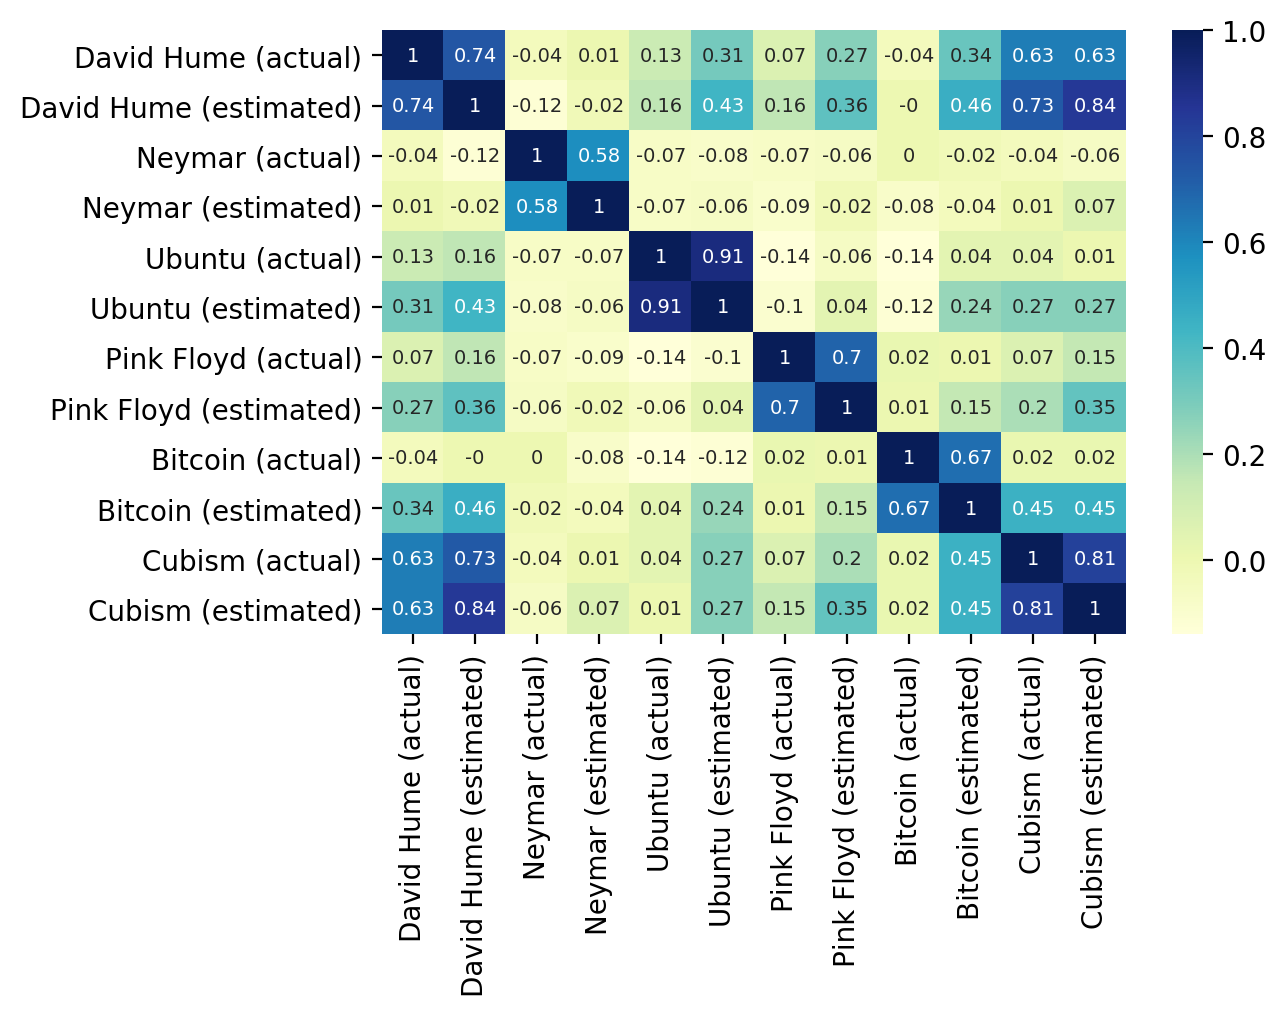

In [19]:
plt.rcParams['figure.dpi'] = 200

import seaborn as sns

corr = round(dfall.corr(),2)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True,
           cmap="YlGnBu",
           annot_kws={"size": 7})

In [68]:
mean_pageviews = np.array([get_pageviews_unstandarized("David Hume").mean().values[0],
get_pageviews_unstandarized("Neymar").mean().values[0],
get_pageviews_unstandarized("Ubuntu").mean().values[0],
get_pageviews_unstandarized("Pink Floyd").mean().values[0],
get_pageviews_unstandarized("Bitcoin").mean().values[0],
get_pageviews_unstandarized("Cubism").mean().values[0]])

correlations = np.array([corr.iloc[0,1],
corr.iloc[2,3],
corr.iloc[4,5],
corr.iloc[6,7],
corr.iloc[8,9],
corr.iloc[10,11]])

np.corrcoef(mean_pageviews, correlations)

array([[ 1.       , -0.7214626],
       [-0.7214626,  1.       ]])

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

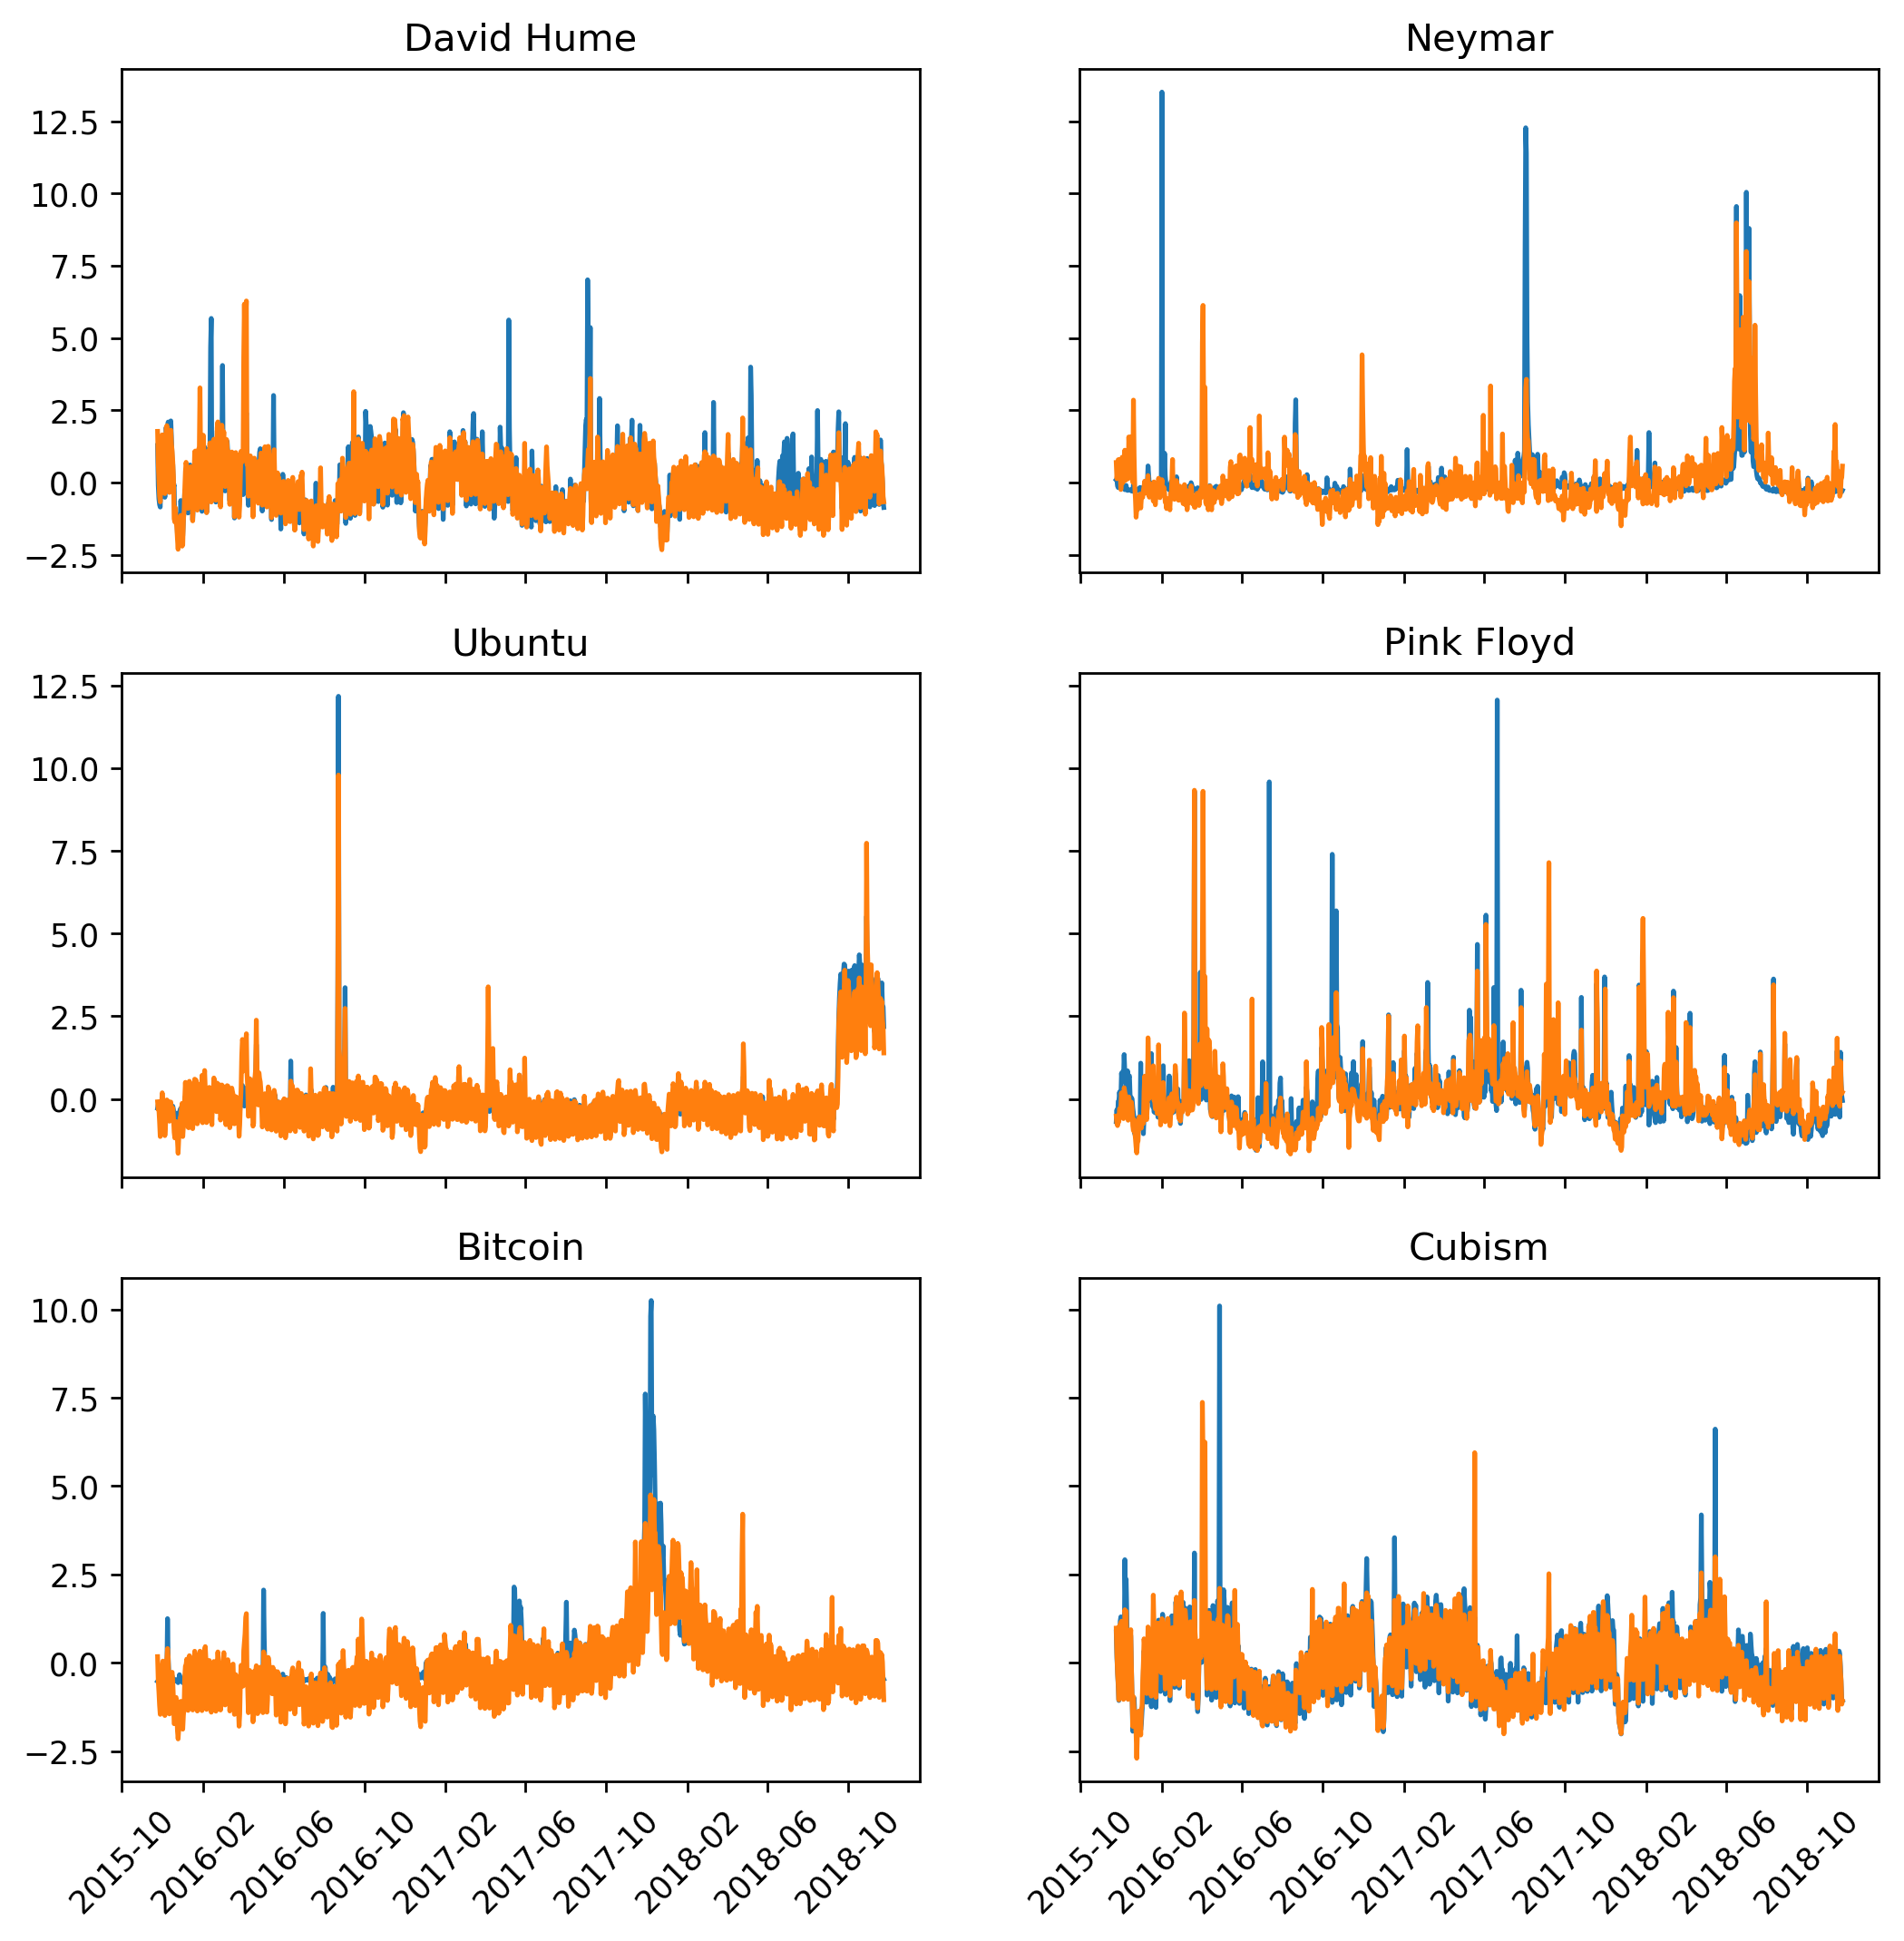

In [61]:
plt.rcParams['figure.figsize'] = (10, 10)


f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex='col', sharey='row')

ax1.plot((hume_original_views-hume_original_views.mean())/hume_original_views.std())
ax1.plot((hume_mean_views-hume_mean_views.mean())/hume_mean_views.std())
ax1.set_title("David Hume")

ax2.plot((neymar_original_views-neymar_original_views.mean())/neymar_original_views.std())
ax2.plot((neymar_mean_views-neymar_mean_views.mean())/neymar_mean_views.std())
ax2.set_title("Neymar")

ax3.plot((ubuntu_original_views-ubuntu_original_views.mean())/ubuntu_original_views.std())
ax3.plot((ubuntu_mean_views-ubuntu_mean_views.mean())/ubuntu_mean_views.std())
ax3.set_title("Ubuntu")

ax4.plot((pink_original_views-pink_original_views.mean())/pink_original_views.std())
ax4.plot((pink_mean_views-pink_mean_views.mean())/pink_mean_views.std())
ax4.set_title("Pink Floyd")

ax5.plot((bitcoin_original_views-bitcoin_original_views.mean())/bitcoin_original_views.std())
ax5.plot((bitcoin_mean_views-bitcoin_mean_views.mean())/bitcoin_mean_views.std())
ax5.set_title("Bitcoin")

ax6.plot((cubism_original_views-cubism_original_views.mean())/cubism_original_views.std())
ax6.plot((cubism_mean_views-cubism_mean_views.mean())/cubism_mean_views.std())
ax6.set_title("Cubism")

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45)

[Text(0,0.5,'Correlation (actual and estimated)'),
 Text(0.5,0,'Number of pageviews')]

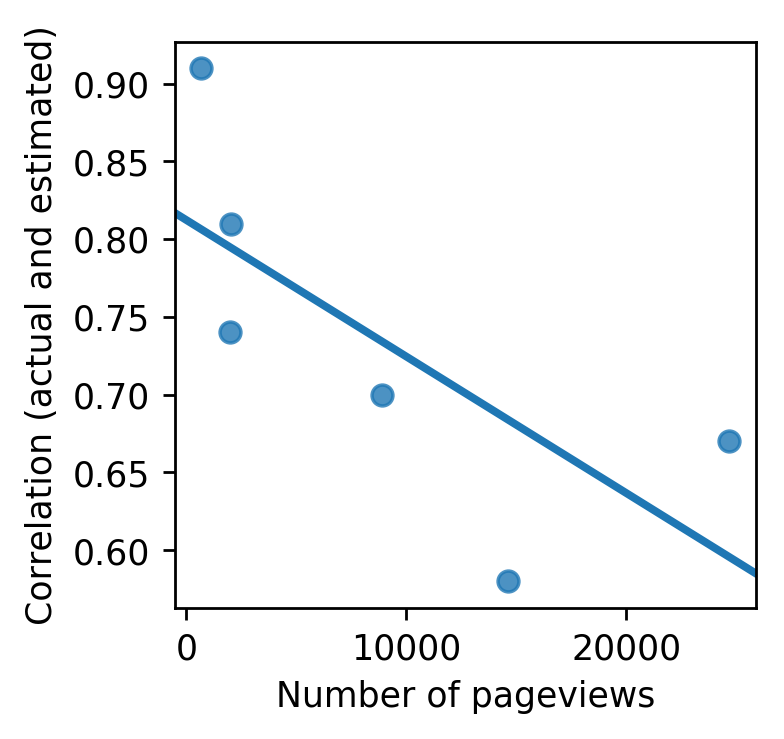

In [74]:
plt.rcParams['figure.figsize'] = (3, 3)

import seaborn as sns

ax = sns.regplot(x = mean_pageviews, y = correlations, robust=True, ci=None)
ax.set(xlabel='Number of pageviews', ylabel='Correlation (actual and estimated)')

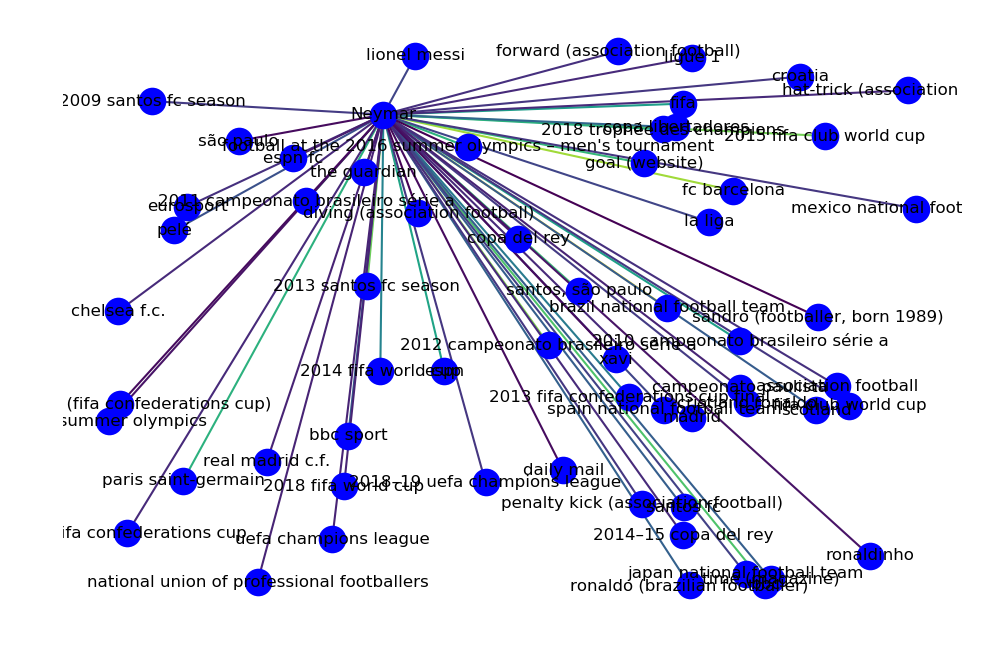

In [411]:
source = list((wiki_links.shape[0]-1)*["Neymar"])
target = list((wiki_links.index[0:-1]))
weight = wiki_links.values[0:-1].tolist()
weight = [item for sublist in weight for item in sublist]

network = pd.DataFrame({"source": source, "target": target , "weight": weight})

G = nx.from_pandas_edgelist(network, edge_attr = "weight")
nx.draw(G, pos=nx.random_layout(G), with_labels=True, node_size = 150, 
        font_size = 8, node_color = 'b', edge_color = np.log(weight))

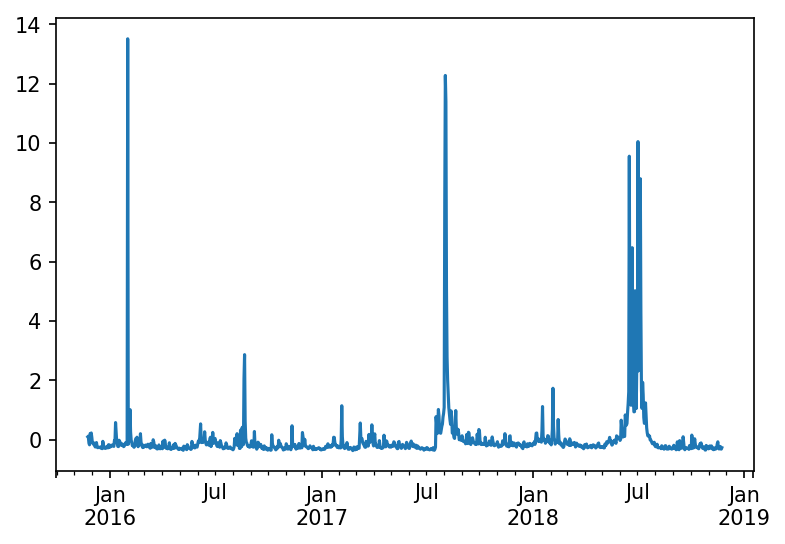

In [412]:
original_views.plot()

In [491]:
wiki_links = get_wikipedia_links("Neymar")[0]

wiki_links_list = set(wiki_links.index) - set([originalterm.lower()])
df = pd.DataFrame()
for term in wiki_links_list:
    newdf = get_pageviews(term)
    df = pd.concat([df,newdf], axis = 1, sort=True)

df = df.reindex(sorted(df.columns), axis=1)


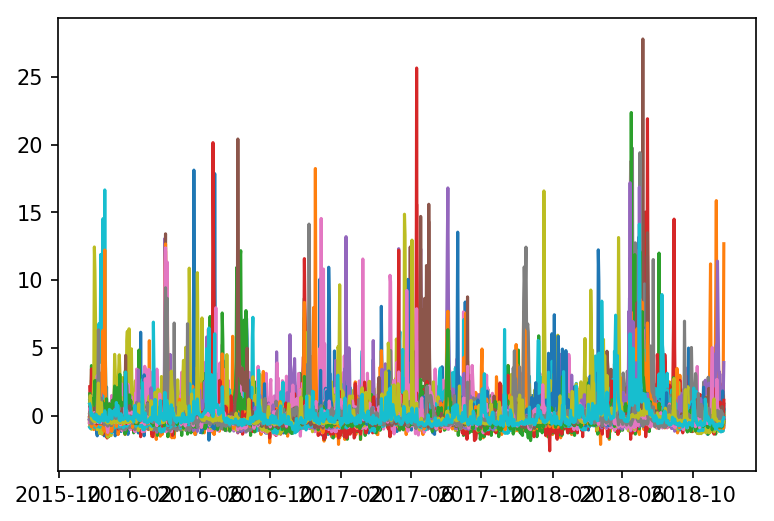

In [500]:
for i in range(60):
    plt.plot(df.iloc[:,i])

In [504]:
weights = wiki_links[0:-1].sort_index().values
weights = [item for sublist in weights for item in sublist]
mean_views = df.multiply(weights, axis = 1).sum(axis=1)/sum(weights)

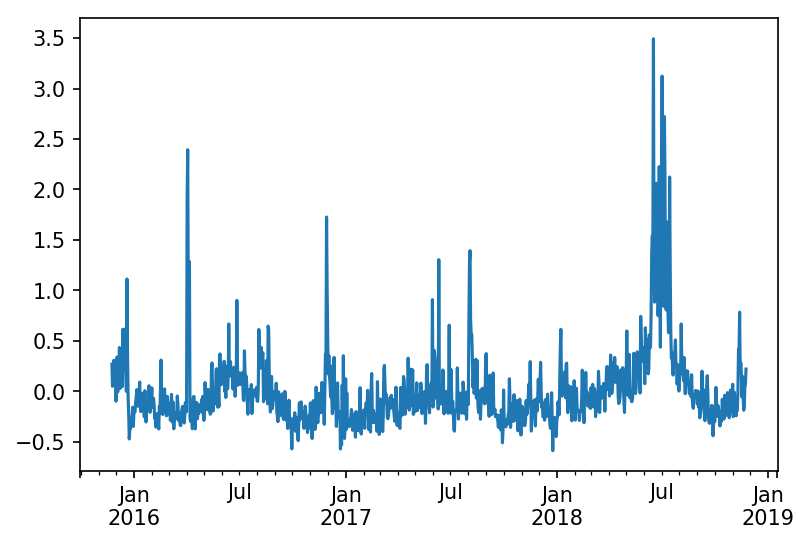

In [505]:
mean_views.plot()